Kvasir dataset split into neg/pos and trained using Resnet50 without augmentation. Getting some decent results after training on resampled data with large step-size.  
- Class weighting  
- Resampling  
- Initial Bias-estimation
- Decreasing learning rate

### Loading data

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
import time
import os
import pathlib
import matplotlib.pyplot as plt
 
# Some stuff to make utils-function work
import sys
sys.path.append('../utils')
from data_prep import create_dataset, print_class_info, show_image
%load_ext autoreload
%autoreload 2

# Jupyter-specific
%matplotlib inline

Some parameters

In [11]:
data_dir = pathlib.Path('/home/henrik/master-thesis/data/hyper-kvasir/labeled/')

config = {
    # Dataset
    "data_dir": data_dir,
    "cache_dir": "./cache",
    "ds_info": 'hyp-kva',
    "resample": False,
    "shuffle_buffer_size": 0,
    "neg_class": ['normal-cecum'],
    "outcast": None,
    # Model
    "model": 'EfficientNetB0',
    "num_epochs": 15,
    "batch_size": 32,
    "img_shape": (128, 128, 3),
    "learning_rate": 0.01,
    "optimizer": 'Adam',
    "final_activation": 'softmax',
    # Callbacks
    "learning_schedule": True,
    "checkpoint": False,
    "early_stopping": False,
    "early_stopping_patience": 10,
    "decay_rate": 0.05,              # higher number gives steeper dropoff
    # Misc
    "verbosity": 1
    }

model_name = '{}x{}x{}_{}_{}'.format(config["num_epochs"], config["batch_size"], 
                                     config["img_shape"][1], config["ds_info"], config["model"])

fine_tune_from = 130
fine_tune_epochs = 30
early_stopping_patience = config["early_stopping_patience"]

Create training, testing and validation dataset from utils/data_prep.py.  
Returns tf.dataset for shuffled, cached and batched data

In [12]:
train_ds, test_ds, val_ds, params = create_dataset(config)

train_steps = params["train_size"] // config["batch_size"]
test_steps = params["test_size"] // config["batch_size"]
val_steps = params["val_size"] // config["batch_size"]
class_names = params["class_names"]

barretts-short-segment      :   53 | 0.50%
bbps-0-1                    :  646 | 6.06%
impacted-stool              :  131 | 1.23%
bbps-2-3                    : 1148 | 10.77%
hemorrhoids                 :    6 | 0.06%
ulcerative-colitis-grade-2  :  443 | 4.15%
normal-z-line               :  932 | 8.74%
retroflex-stomach           :  764 | 7.17%
esophagitis-b-d             :  260 | 2.44%
dyed-resection-margins      :  989 | 9.28%
ileum                       :    9 | 0.08%
ulcerative-colitis-0-1      :   35 | 0.33%
dyed-lifted-polyps          : 1002 | 9.40%
polyps                      : 1028 | 9.64%
ulcerative-colitis-2-3      :   28 | 0.26%
ulcerative-colitis-1-2      :   11 | 0.10%
ulcerative-colitis-grade-3  :  133 | 1.25%
retroflex-rectum            :  391 | 3.67%
esophagitis-a               :  403 | 3.78%
ulcerative-colitis-grade-1  :  201 | 1.89%
pylorus                     :  999 | 9.37%
cecum                       : 1009 | 9.46%
barretts                    :   41 | 0.38%

Total num

# Step 1
Train a teacher model on labeled images

In [13]:
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.keras import layers

### Create and compile the model

In [14]:
from efficientnet import EfficientNetB0 as EfficientNet

# from efficientnet import center_crop_and_resize, preprocess_input

In [15]:
efficientnet_base = EfficientNet(
    weights="imagenet",
    include_top=False, 
    input_shape=config["img_shape"]
)

In [16]:
# Unfreeze the layers. I.E we're just using the pre-trained weights as initial weigths and biases and train over them
efficientnet_base.trainable = True

# Define model
en_model = Sequential()
en_model.add(efficientnet_base)
en_model.add(layers.GlobalAveragePooling2D())
# en_model.add(layers.Dropout(0.2))
# en_model.add(layers.Dense(256, activation='relu'))
en_model.add(layers.Dense(params["num_classes"], activation=config["final_activation"]))

if config['optimizer'] == 'Adam':
    opt = tf.keras.optimizers.Adam(learning_rate=config["learning_rate"])
elif config['optimizer'] == 'SGD':
    opt = tf.keras.optimizers.SGD(learning_rate=config["learning_rate"])

en_model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

In [17]:
en_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 4, 4, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 23)                29463     
Total params: 4,079,027
Trainable params: 4,037,011
Non-trainable params: 42,016
_________________________________________________________________


### Callbacks

In [18]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, LearningRateScheduler
import datetime

In [19]:
# By using LearnignRateScheduler
initial_learning_rate = config["learning_rate"]
decay_steps = params["train_size"] // config["batch_size"]
batch_size = config['batch_size']
decay_rate = config['decay_rate']

def schedule(epoch):
    # calculate new learning rate
    learning_rate = initial_learning_rate / (1 + decay_rate * (epoch*batch_size) / decay_steps)
    
    # update tensorboard
    tf.summary.scalar(name='learning_rate', data=learning_rate, step=epoch)
    return learning_rate

log_dir="./logs/{}/".format(config["model"]) + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(log_dir + "/metrics")
file_writer.set_as_default()

lr_schedule_cb = LearningRateScheduler(schedule, verbose=1)
earlystopp_cb = EarlyStopping(monitor='val_loss',verbose=1, patience=early_stopping_patience, restore_best_weights=True)
checkpoint_cb = ModelCheckpoint(filepath='./models/best_cp-{epoch:03d}.hdf', monitor='val_loss', save_best_only=True, mode='auto')
tensorboard_cb = TensorBoard(log_dir=log_dir, update_freq='batch')

callbacks = [tensorboard_cb]
if config["early_stopping"]: callbacks.append(earlystopp_cb)
if config["learning_schedule"]: callbacks.append(lr_schedule_cb)
if config["checkpoint"]: callbacks.append(checkpoint_cb)

# Write config dictionary to text file
f = open(log_dir+"/config.txt","w")
f.write(str(config))
f.close()

In [20]:
history = en_model.fit(
    train_ds,
    steps_per_epoch = train_steps,
    epochs = config["num_epochs"],
    validation_data = test_ds,
    validation_steps = test_steps,
    validation_freq = 1,
    callbacks = callbacks
)

Train for 233 steps, validate for 49 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/15
233/233 [==============================] - 24s 105ms/step - loss: 1.0871 - sparse_categorical_accuracy: 0.6499 - val_loss: 7.6923 - val_sparse_categorical_accuracy: 0.3418

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009931798806479113.
Epoch 2/15
233/233 [==============================] - 17s 74ms/step - loss: 0.6645 - sparse_categorical_accuracy: 0.7480 - val_loss: 3.1098 - val_sparse_categorical_accuracy: 0.4050

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009864521591871294.
Epoch 3/15
233/233 [==============================] - 17s 75ms/step - loss: 0.5881 - sparse_categorical_accuracy: 0.7791 - val_loss: 1.0016 - val_sparse_categorical_accuracy: 0.6990

Epoch 00004: LearningRateScheduler reducing learning rate to 0.009798149705634989.
Epoch 4/15
233/233 [==============================] - 17s 74ms/step - loss: 0.5346 - spars

In [21]:
best_acc =  str(history.history["val_sparse_categorical_accuracy"][-1])[2:4]
# en_model.save('./models/{}.h5'.format(model_name+best_acc))

## Evaluate the model

In [22]:
# Check if validation data is cached
cache_dir = config["cache_dir"]
img_width = config["img_shape"][0]
ds_info = config["ds_info"]
filename = "{}/{}_{}_val.tfcache.index".format(cache_dir, img_width, ds_info)

cached = os.path.isfile(filename)
if not cached:
    # Iterate over dataset to initialize caching
    for batch in val_ds.take(params["val_size"]):
        pass

In [23]:
en_evaluate = en_model.evaluate(val_ds, verbose=2, steps=val_steps)

# Write evaluate dictionary to text file
f = open(log_dir+"/evaluate.txt","w")
f.write( str(en_evaluate) )
f.close()

49/49 - 1s - loss: 1.1778 - sparse_categorical_accuracy: 0.7085


In [24]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

if config["learning_schedule"]: lr = history.history['lr']
epochs_range = range(history.epoch[-1]+1)

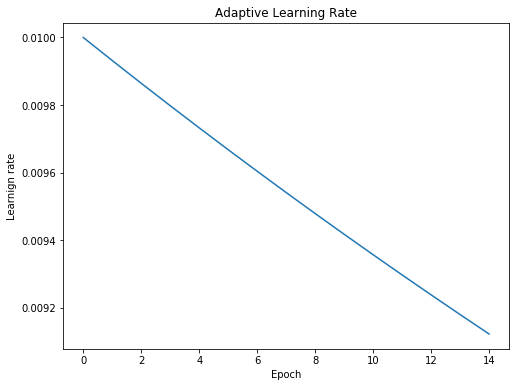

In [25]:
if config["learning_schedule"]:
    # Plot the learning rate
    plt.figure(figsize=(8, 6))
    plt.plot(epochs_range, lr, label='Learning Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Learnign rate')
    plt.savefig(log_dir+'/learning_rate.png')
    plt.title('Adaptive Learning Rate');

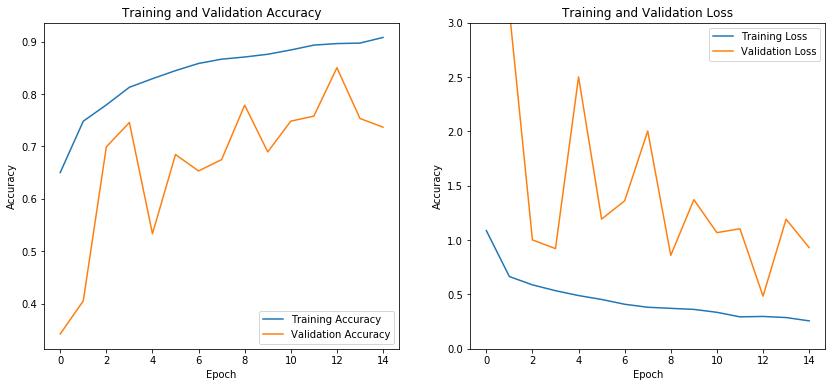

In [26]:
# Plot train-val accuracy and loss
plt.figure(figsize=(14, 6))

# Subplot 1
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
# plt.ylim([0.5, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

# Subplot 2
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylim([0.0, 3])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Loss')
plt.savefig(log_dir+'/accuracy_and_loss.png')
plt.show()

#### Check the predictions on validation dataset

label: ulcerative-colitis-grade-2

 1.40% ulcerative-colitis-grade-2
 1.32% ulcerative-colitis-0-1
55.16% polyps
13.62% ulcerative-colitis-2-3
 2.12% ulcerative-colitis-grade-3
 1.03% retroflex-rectum
24.63% ulcerative-colitis-grade-1


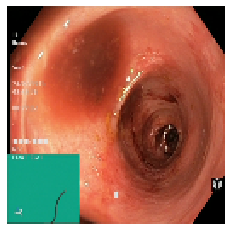

In [59]:
# Take one batch of validation data
for images, labels in val_ds.take(1):
    pass

idx = np.random.randint(0, config["batch_size"])

# Take one image and convert it to numpy
img = images.numpy()[idx]
lab = labels.numpy()[idx]
# Add one dimension
print ("label:", class_names[lab], end='\n\n')
show_image(img)
img = np.expand_dims(img, 0)

prediction = en_model.predict(img, verbose=0)
for i, pred in enumerate(prediction[0]):
    if pred > 0.01: print("{:>5.2f}% {}".format(pred*100, class_names[i]))

## Read in the unlabeled `test` dataset (which are images taken from the training data)

In [60]:
def get_filename(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    # the last item of parts is the filename
    filename = parts[-1]
    return filename

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [config["img_shape"][0], config["img_shape"][1] ])

def process_path(file_path):
    filename = get_filename(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, filename

In [61]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
data_dir_unlabeled_test = pathlib.Path('/home/henrik/master-thesis/data/hyper-kvasir/unlabeled-test/')

ds_size_unlabeled_test = len(list(data_dir_unlabeled_test.glob('*.*g')))

files_string = str(data_dir_unlabeled_test/'*.*g')
list_ds_unlabeled_test = tf.data.Dataset.list_files(files_string)

unlabeled_ds_test = list_ds_unlabeled_test.map(process_path, num_parallel_calls=AUTOTUNE)

Run prediction on one random image, to verify the results after training.

Filename: 01a00d7e-6497-4e49-98c2-d41a0085650dulcerative-colitis-grade-3.jpg
Label: ulcerative-colitis-grade-3

 1.11% bbps-2-3
 8.06% ulcerative-colitis-grade-2
 2.74% ileum
86.33% ulcerative-colitis-grade-1


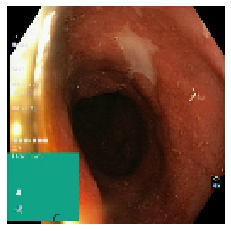

In [72]:
# Print some images and confidence levels to see how to model performs
# Take one image of unlabeled-test set
for img, name in unlabeled_ds_test.take(1):
    # Convert to numpy and add dimension
    print ("Filename:", str(name.numpy())[2:-1])
    print ("Label:", str(name.numpy())[38:-5])
    show_image(img.numpy())
    img = np.expand_dims(img.numpy(), 0)
    prediction = en_model.predict(img, verbose=0)
    print ()
    for i, pred in enumerate(prediction[0]):
        if pred > 0.01: print("{:>5.2f}% {}".format(pred*100, class_names[i]))

Add the findings with probability score higher than threshold to the training dataset

In [80]:
# Create a dataset with 1 sample from training dataset
img, lab = next(iter(train_ds.unbatch().take(1)))
new_samples = tf.data.Dataset.from_tensors((img, lab))

pred_confidence = 0.90
new_samples_counter = 0
img_list = []
lab_list = []

for batch in unlabeled_ds_test.batch(20):
    images, filenames = batch
    batch_preds = en_model.predict(images, verbose=0)
    
    for pred, image in zip(batch_preds, images):
        highest_pred = np.max(pred)
        if highest_pred > pred_confidence:
            pred_idx = np.argmax(pred).astype(np.int32)
            pred_class = class_names[pred_idx]
            
            img_list.append(image)
            lab_list.append(pred_idx)
            
            new_samples_counter += 1
        
print ("Found", new_samples_counter, "new samples from unlabeled_ds_test")

Found 57 new samples from unlabeled_ds_test


In [ ]:
# Create a dataset out of list of findings
new_findings = tf.data.Dataset.from_tensor_slices((img_list, lab_list))

In [ ]:
# Merge new dataset with original
new_train_ds = train_ds.unbatch().take(params["train_size"]).concatenate(new_findings)

print ("Added new samples from unlabeled dataset to the training dataset")

In [ ]:
print ("Training dataset size:", params["train_size"])

num_elements = new_train_ds.reduce(0, lambda x, _: x + 1).numpy()
print ("New size:", num_elements)

## Read in the `full` unlabeled dataset

In [81]:
def get_filename(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    # the last item of parts is the filename
    filename = parts[-1]
    return filename

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [config["img_shape"][0], config["img_shape"][1] ])

def process_path(file_path):
    filename = get_filename(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, filename

In [82]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
data_dir_unlabeled = pathlib.Path('/home/henrik/master-thesis/data/hyper-kvasir/unlabeled/')

ds_size_unlabeled = len(list(data_dir_unlabeled.glob('*.*g')))

files_string = str(data_dir_unlabeled/'*.*g')
list_ds_unlabeled = tf.data.Dataset.list_files(files_string)

unlabeled_ds = list_ds_unlabeled.map(process_path, num_parallel_calls=AUTOTUNE)

print ("Loaded {} images into unlabeled_ds.".format(ds_size_unlabeled))

Loaded 99417 images into unlabeled_ds.


File: ba1d42db-8092-4110-83ab-a11b546679cc.jpg

99.86% polyps


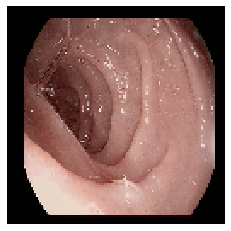

In [98]:
# Run prediction on 1 image
for img, name in unlabeled_ds.take(1):
    # Convert to numpy and add dimension
    print ("File:",str(name.numpy())[2:-1], end='\n\n')
    show_image(img.numpy())
    img = np.expand_dims(img.numpy(), 0)
    prediction = en_model.predict(img, verbose=0)
    
    # If probability above 1% print info
    for i, pred in enumerate(prediction[0]):
         if pred > 0.01: print("{:>5.2f}% {}".format(pred*100, class_names[i]))

## Iterate over unlabeled dataset and predict new sampels

Using 'append to list and convert to tensor'-method
- cache takes too much space

Using batch size of 1

In [ ]:
pred_confidence = 0.99
new_samples_counter = 0
start_time = time.time()
round_time = time.time()
idx = 0
img_list = []
lab_list = []

for batch in unlabeled_ds.batch(1):
    if not idx%1000: 
        print ("{:.1f}s\nBatch {}".format(time.time()-round_time, idx), end='')
        round_time = time.time()
    elif not idx%100:
        print (".",end='')
    images, filenames = batch
    batch_preds = en_model.predict(images, verbose=0)

    for pred, image in zip(batch_preds, images):
        highest_pred = np.max(pred)

        if highest_pred > pred_confidence:
            pred_idx = np.argmax(pred).astype(np.int32)
            #pred_class = class_names[pred_idx]

            img_list.append(image)
            lab_list.append(pred_idx)
            
            new_samples_counter += 1
    idx += 1
        
        
print ("Time: {:.3f} s".format( time.time() - start_time ))
print ("Found", new_samples_counter, "new samples in unlabeled_ds")

Iterate over ds directly

In [ ]:
pred_confidence = 0.99
new_samples_counter = 0
total_time = time.time()
round_time = time.time()
img_list = lab_list = []

for count, (image,label) in enumerate(unlabeled_ds):
    if not count%1000: 
        print ("{:.1f}s\nBatch {}".format(time.time()-round_time, count), end='')
        round_time = time.time()
    elif not count%100:
        print (".",end='')
    img = np.expand_dims(image, 0)
    pred = en_model.predict(img)
    highest_pred = np.max(pred)
    if highest_pred > pred_confidence:
        pred_idx = np.argmax(pred).astype(np.int32)
        #pred_class = class_names[pred_idx]

        img_list.append(image)
        lab_list.append(pred_idx)

        new_samples_counter += 1
        
print ("\nTotal time: {:.3f} s".format( time.time() - total_time ))
print ("Found", new_samples_counter, "new samples in unlabeled_ds")

In [ ]:
new_findings = tf.data.Dataset.from_tensor_slices((img_list, lab_list))

In [ ]:
new_train_ds = train_ds.unbatch().take(params["train_size"]).concatenate(new_findings)

In [ ]:
print ("Training dataset size:", params["train_size"])

num_elements = new_train_ds.reduce(0, lambda x, _: x + 1).numpy()
print ("New size:", num_elements)